In [264]:
import numpy as np
from filterpy.kalman import KalmanFilter
import pandas as pd
import datetime

In [287]:
df = pd.read_csv("Cleaned Datasets/US_Full_Quarterly.csv")
df["Log GDP"] = np.log(df["GDP"])
df['Diff Log GDP'] = df['Log GDP'] - df['Log GDP'].shift(1)
df.set_index("DATE", drop=True, inplace=True)
variables = ['Diff Log GDP', 'College','Fertility']
df_var = df[variables]
df_var.dropna(inplace=True)
df_var = df_var[df_var.index <= "2017"]
df_var

/var/folders/vj/8t2xdhb577n2gr_0n_gppv480000gn/T/ipykernel_4357/2821337664.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_var.dropna(inplace=True)


,Diff Log GDP,College,Fertility
DATE,,,
1960-01-01,0.026229,7.70,3.6540
1960-04-01,-0.002894,7.70,3.6540
1960-07-01,0.008326,7.70,3.6540
1960-10-01,-0.009960,7.70,3.6540
1961-01-01,0.008885,8.04,3.6200
...,...,...,...
2015-10-01,0.001819,32.50,1.8435
2016-01-01,0.004913,33.40,1.8205
2016-04-01,0.009978,33.40,1.8205


In [288]:
# Define the function to calculate AIC
def calculate_aic(filtered_states, true_state, k, log_l):

    n = len(filtered_states)

    # AIC calculation
    aic = 2 * k * (1 + (k+1)/(n-k)) - 2 * log_l
    return aic

In [289]:
def Kalman(dimensionSearch=10):

    aic = np.inf
    filtered_state = []

    x_opt = 0
    F_opt = 0
    H_opt = 0

    # Iterate to find best dimensions
    for d in range(1, dimensionSearch):
        # Initialize 10 random points
        for i in range(10):
            log_likelihood = 0
            f = KalmanFilter(dim_x=d, dim_z=3)
            f.x = np.random.normal(size=(d,1))
            f.F = np.random.normal(size=(d,d))
            f.H = np.random.normal(size=(3,d))

            # Run Kalman filter
            for z in df_var.values:
                f.predict()
                f.update(z)
                log_likelihood += f.log_likelihood_of(z)
                filtered_state.append(f.x.flatten())

            # Compute and compare AIC
            curr_aic = calculate_aic(filtered_state, df, d, log_likelihood)
            if curr_aic < aic:
                aic = curr_aic
                optimalModel = f
                x_opt = f.x
                F_opt = f.F
                H_opt = f.H
    
    return optimalModel, x_opt, F_opt, H_opt

In [290]:
optimalModel, x, F, H = Kalman()

,Diff Log GDP,College,Fertility
DATE,,,
240,-5.088827e+05,1.551228e+06,-6.503643e+05
241,-6.663812e+05,3.204623e+06,-1.151604e+06
242,-2.385838e+06,7.513009e+06,-3.109932e+06
243,-3.434826e+06,1.570561e+07,-5.728877e+06
244,-1.124907e+07,3.642672e+07,-1.491891e+07
245,-1.748984e+07,7.688938e+07,-2.838309e+07
246,-5.330400e+07,1.767688e+08,-7.175730e+07
247,-8.824088e+07,3.761004e+08,-1.401730e+08
248,-2.536834e+08,8.584252e+08,-3.458968e+08


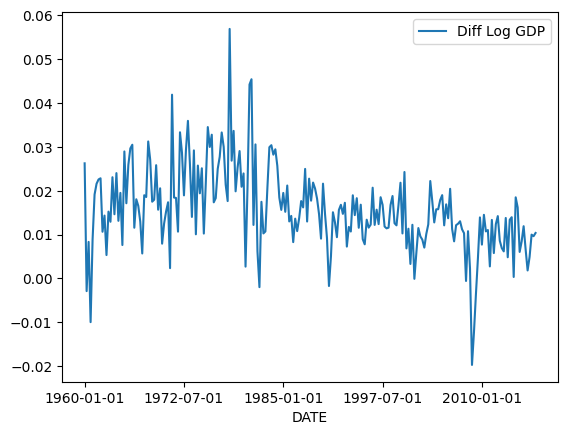

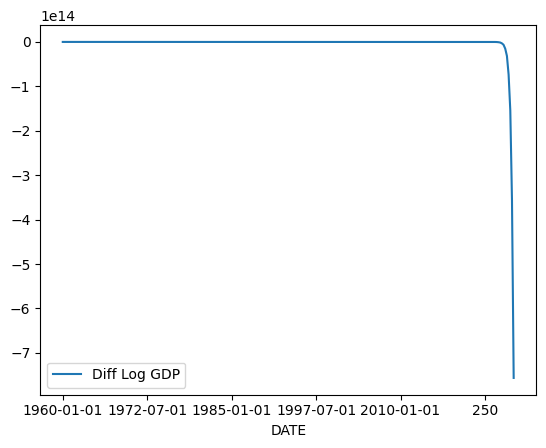

In [291]:
# Graph the results
df_var.plot(y="Diff Log GDP")

def KalmanPredict(optimalModel, df, yearsToPredict=10): # TODO: Obviously, there are some big problems with prediction right now. The values blow up.
    out = df.copy()
    x0 = x.copy()

    for i in range(yearsToPredict * 4):
        x1 = F@x0
        z = (H@x1).reshape(3,)
        out.loc[len(out.index)] = z
        x0 = x1.copy()
        
    return out

newDataFrame = KalmanPredict(optimalModel, df_var)
newDataFrame.plot(y='Diff Log GDP', use_index=True)
newDataFrame[240:260]

In [304]:
def Kalman1d(dimension=1):

    aic = np.inf
    filtered_state = []

    x_opt = 0
    F_opt = 0
    H_opt = 0

    # Iterate to find best dimensions
    # Initialize 10 random points
    log_likelihood = 0
    f = KalmanFilter(dim_x=1, dim_z=1)
    f.x = np.random.normal(size=(1,1))
    f.F = np.random.normal(size=(1,1))
    f.H = np.random.normal(size=(1,1))

    # Run Kalman filter
    for z in df_var['Diff Log GDP'].values:
        f.predict()
        f.update(z)
        log_likelihood += f.log_likelihood_of(z)
        filtered_state.append(f.x.flatten())
    
    return f, f.x, f.F, f.H

In [320]:
f, x, F, H = Kalman1d()

array([[0.02975833]])

<AxesSubplot: xlabel='DATE'>

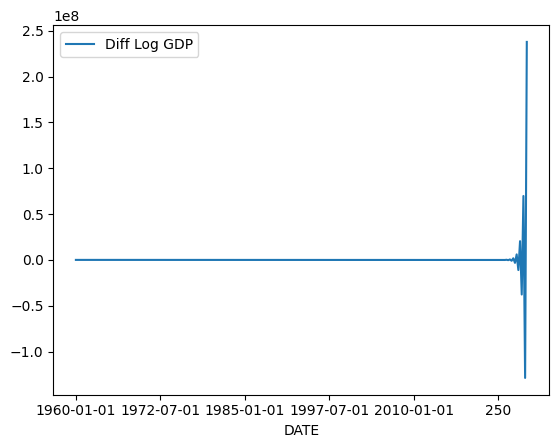

In [327]:
def KalmanPredict1d(optimalModel, df, yearsToPredict=10): # TODO: Obviously, there are some big problems with prediction right now. The values blow up.
    out = df.copy()
    x0 = x.copy()

    for i in range(yearsToPredict * 4):
        x1 = F@x0
        out.loc[len(out.index)] = H@(x1[0])

        x0 = x1.copy() 
    return out

df1dPredict = KalmanPredict1d(f, df_var[['Diff Log GDP']])
df1dPredict.plot(y="Diff Log GDP")